In [11]:
import os

def validate_paths(*paths):
    for path in paths:
        if not os.path.exists(path):
            print(f"Error: The specified path '{path}' does not exist.")
        else:
            if os.path.isfile(path):
                print(f"File found: {path}")
            elif os.path.isdir(path):
                print(f"Directory found: {path}")
            else:
                print(f"Unknown type for path: {path}")

# 경로들을 확인합니다.
zip_file_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV.zip'  # 예시 파일 경로
extract_folder = '/Users/heebonpark/Desktop/업무/영업기회/0829/extracted_data'
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
file1_path = '/Users/heebonpark/Desktop/업무/영업기회/1.영업구역별_주소현행화0725.xlsx'
file2_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')

validate_paths(zip_file_path, extract_folder, output_dir, file1_path, file2_path)


Error: The specified path '/Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV.zip' does not exist.
Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829/extracted_data
Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829
File found: /Users/heebonpark/Desktop/업무/영업기회/1.영업구역별_주소현행화0725.xlsx
File found: /Users/heebonpark/Desktop/업무/영업기회/0829/1.27일_병합(서울,경기,강원).csv


In [15]:
import subprocess
import sys
import pandas as pd
import os
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.backends.backend_pdf import PdfPages
from difflib import SequenceMatcher

# 라이브러리 설치 함수 (이미 설치된 경우 생략 가능)
def install_libraries():
    try:
        import pandas as pd
        import os
        import glob
        import zipfile
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity
        from openpyxl import Workbook
        from openpyxl.utils.dataframe import dataframe_to_rows
        from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as fm
        from matplotlib.backends.backend_pdf import PdfPages
        from difflib import SequenceMatcher
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "openpyxl", "scikit-learn", "matplotlib"])

install_libraries()

# 경로 설정
csv_folder_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV'  # 폴더 경로로 변경
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
file1_path = os.path.join('/Users/heebonpark/Desktop/업무/영업기회', '1.영업구역별_주소현행화0725.xlsx')
file2_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')

# 경로 검증
def validate_paths(*paths):
    for path in paths:
        if not os.path.exists(path):
            print(f"Error: The specified path '{path}' does not exist.")
        else:
            if os.path.isfile(path):
                print(f"File found: {path}")
            elif os.path.isdir(path):
                print(f"Directory found: {path}")
            else:
                print(f"Unknown type for path: {path}")

validate_paths(csv_folder_path, output_dir, file1_path, file2_path)

# 지정된 폴더에서 모든 CSV 파일 목록 가져오기
all_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))

print(f"Found {len(all_files)} CSV files.")

if len(all_files) == 0:
    print("Warning: No CSV files found in the specified directory. Proceeding with an empty DataFrame.")
    dfs = []  # 빈 리스트로 초기화
else:
    # 각 파일을 읽어서 하나의 DataFrame으로 병합
    dfs = []
    for file in all_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            address_columns = [col for col in df.columns if '주소' in col]
            if not address_columns:
                print(f"No address column found in file: {file}")
                continue
            df_filtered = df[df[address_columns[0]].str.contains('서울|경기|강원', na=False)]
            dfs.append(df_filtered)
            print(f"Successfully read and filtered file: {file}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

if len(dfs) == 0:
    concatenated_df = pd.DataFrame()  # 이전 단계에서 파일이 없을 경우 빈 DataFrame 생성
else:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'], inplace=True)

    # '인허가일자' 기준으로 내림차순 정렬
    if '인허가일자' in concatenated_df.columns:
        concatenated_df['인허가일자'] = pd.to_datetime(concatenated_df['인허가일자'], format='%Y%m%d', errors='coerce')
        concatenated_df.sort_values(by='인허가일자', ascending=False, inplace=True)

# 필요한 열만 선택하여 필터링
selected_columns = ['소재지전체주소', '도로명전체주소', '도로명우편번호', '사업장명', '개방서비스명', '인허가일자', '인허가취소', '영업상태명', '폐업일자',
                    '휴업시작일', '휴업종료일', '재개업일자', '소재지전화', '최종수정시점', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '총면적', '소재지면적']

# 존재하는 열만 선택
existing_columns = [col for col in selected_columns if col in concatenated_df.columns]
filtered_df = concatenated_df[existing_columns]

# CSV 파일로 저장
os.makedirs(output_dir, exist_ok=True)
output_csv_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')
filtered_df.to_csv(output_csv_path, index=False, encoding='cp949')

# 엑셀 파일 읽기
df1 = pd.read_excel(file1_path)
df2 = pd.read_csv(output_csv_path, encoding='cp949')

# 주소 정규화 함수
def normalize_address(address):
    if pd.isna(address):
        return None
    address = address.strip()
    address = address.replace('강원특별자치도', '강원도')
    address = address.replace('서울특별시', '서울시')
    address = address.replace(' ', '')
    address = address.replace('-', '')
    if '*' in address or len(address) < 10:  # 길이가 너무 짧은 경우는 None으로 처리
        return None
    return address

# 유사도 비교를 위한 다양한 방식 추가
def get_best_match(address, df_choices, threshold=0.7):
    if pd.isna(address):
        return None

    # 유사도 측정을 위한 다양한 방법 사용
    best_score = 0
    best_match = None

    for choice in df_choices:
        # TF-IDF 및 코사인 유사도
        tfidf_vec = vectorizer.transform([choice])
        cosine_sim = cosine_similarity(vectorizer.transform([address]), tfidf_vec).flatten()[0]

        # 레벤슈타인 거리 기반 유사도 (텍스트 유사도)
        seq_match = SequenceMatcher(None, address, choice)
        seq_similarity = seq_match.ratio()

        # 최고 유사도 채택
        score = max(cosine_sim, seq_similarity)
        if score > best_score:
            best_score = score
            best_match = choice

    if best_score >= threshold:
        return best_match
    return None

# df1의 주소 정규화
df1['full_address'] = df1[['주소시', '주소군구', '주소동']].astype(str).agg(' '.join, axis=1).apply(normalize_address)
df1 = df1.dropna(subset=['full_address'])

# df2의 주소 정규화
df2['소재지전체주소'] = df2['소재지전체주소'].astype(str).apply(normalize_address)
df2['도로명전체주소'] = df2['도로명전체주소'].astype(str).apply(normalize_address)
df2 = df2.dropna(subset=['소재지전체주소', '도로명전체주소'])

# TF-IDF 벡터화
vectorizer = TfidfVectorizer().fit(df1['full_address'])
tfidf_matrix = vectorizer.transform(df1['full_address'])

# 유사한 주소 매핑
choices = df1['full_address'].tolist()
df2['matched_address_소재지'] = df2['소재지전체주소'].apply(lambda x: get_best_match(x, choices))
df2['matched_address_도로명'] = df2['도로명전체주소'].apply(lambda x: get_best_match(x, choices))

df2['matched_address'] = df2.apply(lambda x: x['matched_address_소재지'] if pd.notna(x['matched_address_소재지']) else x['matched_address_도로명'], axis=1)

# 매핑되지 않은 항목 확인
unmatched = df2[df2['matched_address'].isna()]
print("매핑되지 않은 항목 수:", len(unmatched))

# 평수 계산을 위한 열 존재 확인 및 병합
merge_columns = ['full_address', '관리지사', 'SP담당']
if '총면적' in df1.columns:
    merge_columns.append('총면적')
if '소재지면적' in df1.columns:
    merge_columns.append('소재지면적')

df_merged = df2.merge(df1[merge_columns], left_on='matched_address', right_on='full_address', how='left', suffixes=('', '_df1'))

# 매핑 결과 확인
print("매핑 후 관리지사 및 SP담당이 비어있는 행 수:", df_merged[['관리지사', 'SP담당']].isna().sum())

# 평수 계산 (1평 = 3.305785 m^2)
def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]

        # 필터링된 데이터 개수 확인
        print(f"전체 시트에서 영업/정상 데이터 수: {len(df_active)}")

        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = 'd:/영업기회자료/0826'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0827일.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '0827일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=False).index]

# 시각화 및 PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    status_counts.plot(kind='bar', stacked=True, ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=16)
    ax1.set_xlabel('관리지사', fontsize=12)
    ax1.set_ylabel('건수', fontsize=12)
    ax1.legend(title='영업상태명', fontsize=10, title_fontsize='13')
    plt.xticks(rotation=90)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']
    status_counts_sp = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
    status_counts_sp = status_counts_sp.loc[status_counts_sp.sum(axis=1).sort_values(ascending=True).index]

    fig2, ax2 = plt.subplots(figsize=(16, 12))
    status_counts_sp.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'])
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
    ax2.set_xlabel('건수', fontsize=14)
    ax2.set_ylabel('SP담당자', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"전체 영업상태명 집계현황 PDF가 생성되었습니다: {pdf_path}")

# 평수 계산 (1평 = 3.305785 m^2)
def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]

        # 필터링된 데이터 개수 확인
        print(f"전체 시트에서 영업/정상 데이터 수: {len(df_active)}")

        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0827일.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '0827일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=False).index]

# 시각화 및 PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    status_counts.plot(kind='bar', stacked=True, ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=16)
    ax1.set_xlabel('관리지사', fontsize=12)
    ax1.set_ylabel('건수', fontsize=12)
    ax1.legend(title='영업상태명', fontsize=10, title_fontsize='13')
    plt.xticks(rotation=90)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']
    status_counts_sp = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
    status_counts_sp = status_counts_sp.loc[status_counts_sp.sum(axis=1).sort_values(ascending=True).index]

    fig2, ax2 = plt.subplots(figsize=(16, 12))
    status_counts_sp.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'])
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
    ax2.set_xlabel('건수', fontsize=14)
    ax2.set_ylabel('SP담당자', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"전체 영업상태명 집계현황 PDF가 생성되었습니다: {pdf_path}")



Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV
Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829
File found: /Users/heebonpark/Desktop/업무/영업기회/1.영업구역별_주소현행화0725.xlsx
File found: /Users/heebonpark/Desktop/업무/영업기회/0829/1.27일_병합(서울,경기,강원).csv
Found 195 CSV files.
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_09_30_12_P_수질오염원설치시설기타.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_03_05_01_P_게임물배급업.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_11_46_01_P_민방위급수시설.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_10_41_01_P_체육도장업.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_04_16_01_P_인쇄사.csv
Succes

/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:203: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop_duplicates(inplace=True)


전체 시트에서 영업/정상 데이터 수: 21006
전체 시트에서 영업/정상 데이터 수: 100
전체 시트에서 영업/정상 데이터 수: 63
전체 시트에서 영업/정상 데이터 수: 54
전체 시트에서 영업/정상 데이터 수: 83
전체 시트에서 영업/정상 데이터 수: 33
전체 시트에서 영업/정상 데이터 수: 40
전체 시트에서 영업/정상 데이터 수: 28
전체 시트에서 영업/정상 데이터 수: 50
전체 시트에서 영업/정상 데이터 수: 14
전체 시트에서 영업/정상 데이터 수: 75
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 27
전체 시트에서 영업/정상 데이터 수: 46
전체 시트에서 영업/정상 데이터 수: 3
전체 시트에서 영업/정상 데이터 수: 109
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 25
전체 시트에서 영업/정상 데이터 수: 1
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 20
전체 시트에서 영업/정상 데이터 수: 26
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 11
전체 시트에서 영업/정상 데이터 수: 21854


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:318: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:318: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:318: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:318: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:318

전체 영업상태명 집계현황 PDF가 생성되었습니다: d:/영업기회자료/0826/전체_영업상태명_집계현황.pdf
전체 시트에서 영업/정상 데이터 수: 21006
전체 시트에서 영업/정상 데이터 수: 100
전체 시트에서 영업/정상 데이터 수: 63
전체 시트에서 영업/정상 데이터 수: 54
전체 시트에서 영업/정상 데이터 수: 83
전체 시트에서 영업/정상 데이터 수: 33
전체 시트에서 영업/정상 데이터 수: 40
전체 시트에서 영업/정상 데이터 수: 28
전체 시트에서 영업/정상 데이터 수: 50
전체 시트에서 영업/정상 데이터 수: 14
전체 시트에서 영업/정상 데이터 수: 75
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 27
전체 시트에서 영업/정상 데이터 수: 46
전체 시트에서 영업/정상 데이터 수: 3
전체 시트에서 영업/정상 데이터 수: 109
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 25
전체 시트에서 영업/정상 데이터 수: 1
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 20
전체 시트에서 영업/정상 데이터 수: 26
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 11
전체 시트에서 영업/정상 데이터 수: 21854


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:469: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:469: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:469: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:469: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2326825779.py:469

전체 영업상태명 집계현황 PDF가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황.pdf


In [17]:
import subprocess
import sys
import pandas as pd
import os
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from matplotlib.backends.backend_pdf import PdfPages
from difflib import SequenceMatcher

def install_libraries():
    try:
        import pandas as pd
        import os
        import glob
        import zipfile
        from sklearn.feature_extraction.text import TfidfVectorizer
        from sklearn.metrics.pairwise import cosine_similarity
        from openpyxl import Workbook
        from openpyxl.utils.dataframe import dataframe_to_rows
        from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
        import matplotlib.pyplot as plt
        import matplotlib.font_manager as fm
        from matplotlib.backends.backend_pdf import PdfPages
        from difflib import SequenceMatcher
    except ImportError:
        subprocess.check_call([sys.executable, "-m", "pip", "install", "pandas", "openpyxl", "scikit-learn", "matplotlib"])

install_libraries()

csv_folder_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV'
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
file1_path = os.path.join('/Users/heebonpark/Desktop/업무/영업기회', '1.영업구역별_주소현행화0725.xlsx')
file2_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')

def validate_paths(*paths):
    for path in paths:
        if not os.path.exists(path):
            print(f"Error: The specified path '{path}' does not exist.")
        else:
            if os.path.isfile(path):
                print(f"File found: {path}")
            elif os.path.isdir(path):
                print(f"Directory found: {path}")
            else:
                print(f"Unknown type for path: {path}")

validate_paths(csv_folder_path, output_dir, file1_path, file2_path)

all_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))

print(f"Found {len(all_files)} CSV files.")

if len(all_files) == 0:
    print("Warning: No CSV files found in the specified directory. Proceeding with an empty DataFrame.")
    dfs = []
else:
    dfs = []
    for file in all_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            address_columns = [col for col in df.columns if '주소' in col]
            if not address_columns:
                print(f"No address column found in file: {file}")
                continue
            df_filtered = df[df[address_columns[0]].str.contains('서울|경기|강원', na=False)]
            dfs.append(df_filtered)
            print(f"Successfully read and filtered file: {file}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

if len(dfs) == 0:
    concatenated_df = pd.DataFrame()
else:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'], inplace=True)

    if '인허가일자' in concatenated_df.columns:
        concatenated_df['인허가일자'] = pd.to_datetime(concatenated_df['인허가일자'], format='%Y%m%d', errors='coerce')
        concatenated_df.sort_values(by='인허가일자', ascending=False, inplace=True)

selected_columns = ['소재지전체주소', '도로명전체주소', '도로명우편번호', '사업장명', '개방서비스명', '인허가일자', '인허가취소', '영업상태명', '폐업일자',
                    '휴업시작일', '휴업종료일', '재개업일자', '소재지전화', '최종수정시점', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '총면적', '소재지면적']

existing_columns = [col for col in selected_columns if col in concatenated_df.columns]
filtered_df = concatenated_df[existing_columns]

os.makedirs(output_dir, exist_ok=True)
output_csv_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')
filtered_df.to_csv(output_csv_path, index=False, encoding='cp949')

df1 = pd.read_excel(file1_path)
df2 = pd.read_csv(output_csv_path, encoding='cp949')

def normalize_address(address):
    if pd.isna(address):
        return None
    address = address.strip()
    address = address.replace('강원특별자치도', '강원도')
    address = address.replace('서울특별시', '서울시')
    address = address.replace(' ', '')
    address = address.replace('-', '')
    if '*' in address or len(address) < 10:
        return None
    return address

def get_best_match(address, df_choices, threshold=0.7):
    if pd.isna(address):
        return None

    best_score = 0
    best_match = None

    for choice in df_choices:
        tfidf_vec = vectorizer.transform([choice])
        cosine_sim = cosine_similarity(vectorizer.transform([address]), tfidf_vec).flatten()[0]

        seq_match = SequenceMatcher(None, address, choice)
        seq_similarity = seq_match.ratio()

        score = max(cosine_sim, seq_similarity)
        if score > best_score:
            best_score = score
            best_match = choice

    if best_score >= threshold:
        return best_match
    return None

df1['full_address'] = df1[['주소시', '주소군구', '주소동']].astype(str).agg(' '.join, axis=1).apply(normalize_address)
df1 = df1.dropna(subset=['full_address'])

df2['소재지전체주소'] = df2['소재지전체주소'].astype(str).apply(normalize_address)
df2['도로명전체주소'] = df2['도로명전체주소'].astype(str).apply(normalize_address)
df2 = df2.dropna(subset=['소재지전체주소', '도로명전체주소'])

vectorizer = TfidfVectorizer().fit(df1['full_address'])
tfidf_matrix = vectorizer.transform(df1['full_address'])

choices = df1['full_address'].tolist()
df2['matched_address_소재지'] = df2['소재지전체주소'].apply(lambda x: get_best_match(x, choices))
df2['matched_address_도로명'] = df2['도로명전체주소'].apply(lambda x: get_best_match(x, choices))

df2['matched_address'] = df2.apply(lambda x: x['matched_address_소재지'] if pd.notna(x['matched_address_소재지']) else x['matched_address_도로명'], axis=1)

unmatched = df2[df2['matched_address'].isna()]
print("매핑되지 않은 항목 수:", len(unmatched))

merge_columns = ['full_address', '관리지사', 'SP담당']
if '총면적' in df1.columns:
    merge_columns.append('총면적')
if '소재지면적' in df1.columns:
    merge_columns.append('소재지면적')

df_merged = df2.merge(df1[merge_columns], left_on='matched_address', right_on='full_address', how='left', suffixes=('', '_df1'))

print("매핑 후 관리지사 및 SP담당이 비어있는 행 수:", df_merged[['관리지사', 'SP담당']].isna().sum())

# SP담당자 누락 확인 및 처리
missing_sp = df_merged[df_merged['SP담당'].isna()]
if not missing_sp.empty:
    print(f"Warning: SP담당자가 누락된 데이터가 {len(missing_sp)}건 있습니다. 'Unknown'으로 설정합니다.")
    df_merged['SP담당'].fillna('Unknown', inplace=True)

def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]

        # 필터링된 데이터 개수 확인
        print(f"전체 시트에서 영업/정상 데이터 수: {len(df_active)}")

        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0827일.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '0827일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=False).index]

# 시각화 및 PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    status_counts.plot(kind='bar', stacked=True, ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=16)
    ax1.set_xlabel('관리지사', fontsize=12)
    ax1.set_ylabel('건수', fontsize=12)
    ax1.legend(title='영업상태명', fontsize=10, title_fontsize='13')
    plt.xticks(rotation=90)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']
    status_counts_sp = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
    status_counts_sp = status_counts_sp.loc[status_counts_sp.sum(axis=1).sort_values(ascending=True).index]

    fig2, ax2 = plt.subplots(figsize=(16, 12))
    status_counts_sp.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'])
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
    ax2.set_xlabel('건수', fontsize=14)
    ax2.set_ylabel('SP담당자', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"전체 영업상태명 집계현황 PDF가 생성되었습니다: {pdf_path}")
def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]

        # 필터링된 데이터 개수 확인
        print(f"전체 시트에서 영업/정상 데이터 수: {len(df_active)}")

        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0827일.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '0827일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=False).index]

# 시각화 및 PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    status_counts.plot(kind='bar', stacked=True, ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=16)
    ax1.set_xlabel('관리지사', fontsize=12)
    ax1.set_ylabel('건수', fontsize=12)
    ax1.legend(title='영업상태명', fontsize=10, title_fontsize='13')
    plt.xticks(rotation=90)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']
    status_counts_sp = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
    status_counts_sp = status_counts_sp.loc[status_counts_sp.sum(axis=1).sort_values(ascending=True).index]

    fig2, ax2 = plt.subplots(figsize=(16, 12))
    status_counts_sp.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'])
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
    ax2.set_xlabel('건수', fontsize=14)
    ax2.set_ylabel('SP담당자', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"전체 영업상태명 집계현황 PDF가 생성되었습니다: {pdf_path}")



Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV
Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829
File found: /Users/heebonpark/Desktop/업무/영업기회/1.영업구역별_주소현행화0725.xlsx
Error: The specified path '/Users/heebonpark/Desktop/업무/영업기회/0829/1.27일_병합(서울,경기,강원).csv' does not exist.
Found 195 CSV files.
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_09_30_12_P_수질오염원설치시설기타.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_03_05_01_P_게임물배급업.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_11_46_01_P_민방위급수시설.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_10_41_01_P_체육도장업.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~202

/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:168: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['SP담당'].fillna('Unknown', inplace=True)
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:185: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop_duplicates(inplace

전체 시트에서 영업/정상 데이터 수: 21006
전체 시트에서 영업/정상 데이터 수: 100
전체 시트에서 영업/정상 데이터 수: 63
전체 시트에서 영업/정상 데이터 수: 54
전체 시트에서 영업/정상 데이터 수: 83
전체 시트에서 영업/정상 데이터 수: 33
전체 시트에서 영업/정상 데이터 수: 40
전체 시트에서 영업/정상 데이터 수: 28
전체 시트에서 영업/정상 데이터 수: 50
전체 시트에서 영업/정상 데이터 수: 14
전체 시트에서 영업/정상 데이터 수: 75
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 27
전체 시트에서 영업/정상 데이터 수: 46
전체 시트에서 영업/정상 데이터 수: 3
전체 시트에서 영업/정상 데이터 수: 109
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 25
전체 시트에서 영업/정상 데이터 수: 1
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 20
전체 시트에서 영업/정상 데이터 수: 26
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 11
전체 시트에서 영업/정상 데이터 수: 21854


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:300: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:300: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:300: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:300: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:300

전체 영업상태명 집계현황 PDF가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황.pdf
전체 시트에서 영업/정상 데이터 수: 21006
전체 시트에서 영업/정상 데이터 수: 100
전체 시트에서 영업/정상 데이터 수: 63
전체 시트에서 영업/정상 데이터 수: 54
전체 시트에서 영업/정상 데이터 수: 83
전체 시트에서 영업/정상 데이터 수: 33
전체 시트에서 영업/정상 데이터 수: 40
전체 시트에서 영업/정상 데이터 수: 28
전체 시트에서 영업/정상 데이터 수: 50
전체 시트에서 영업/정상 데이터 수: 14
전체 시트에서 영업/정상 데이터 수: 75
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 27
전체 시트에서 영업/정상 데이터 수: 46
전체 시트에서 영업/정상 데이터 수: 3
전체 시트에서 영업/정상 데이터 수: 109
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 25
전체 시트에서 영업/정상 데이터 수: 1
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 20
전체 시트에서 영업/정상 데이터 수: 26
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 11
전체 시트에서 영업/정상 데이터 수: 21854


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:449: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:449: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:449: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:449: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/2930258717.py:449

전체 영업상태명 집계현황 PDF가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황.pdf


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/4288075015.py:74: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/4288075015.py:74: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/4288075015.py:74: UserWarning: Gl

관리지사별 영업상태 현황표:
영업상태명  영업/정상     폐업
관리지사               
중앙지사   211.0   73.0
강북지사    76.0   22.0
서대문지사   62.0   22.0
고양지사   333.0  123.0
의정부지사  125.0   43.0
남양주지사   26.0    4.0
원주지사    15.0    7.0
강릉지사     NaN    NaN


findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font family 'Malgun Gothic' not found.
findfont: Font famil

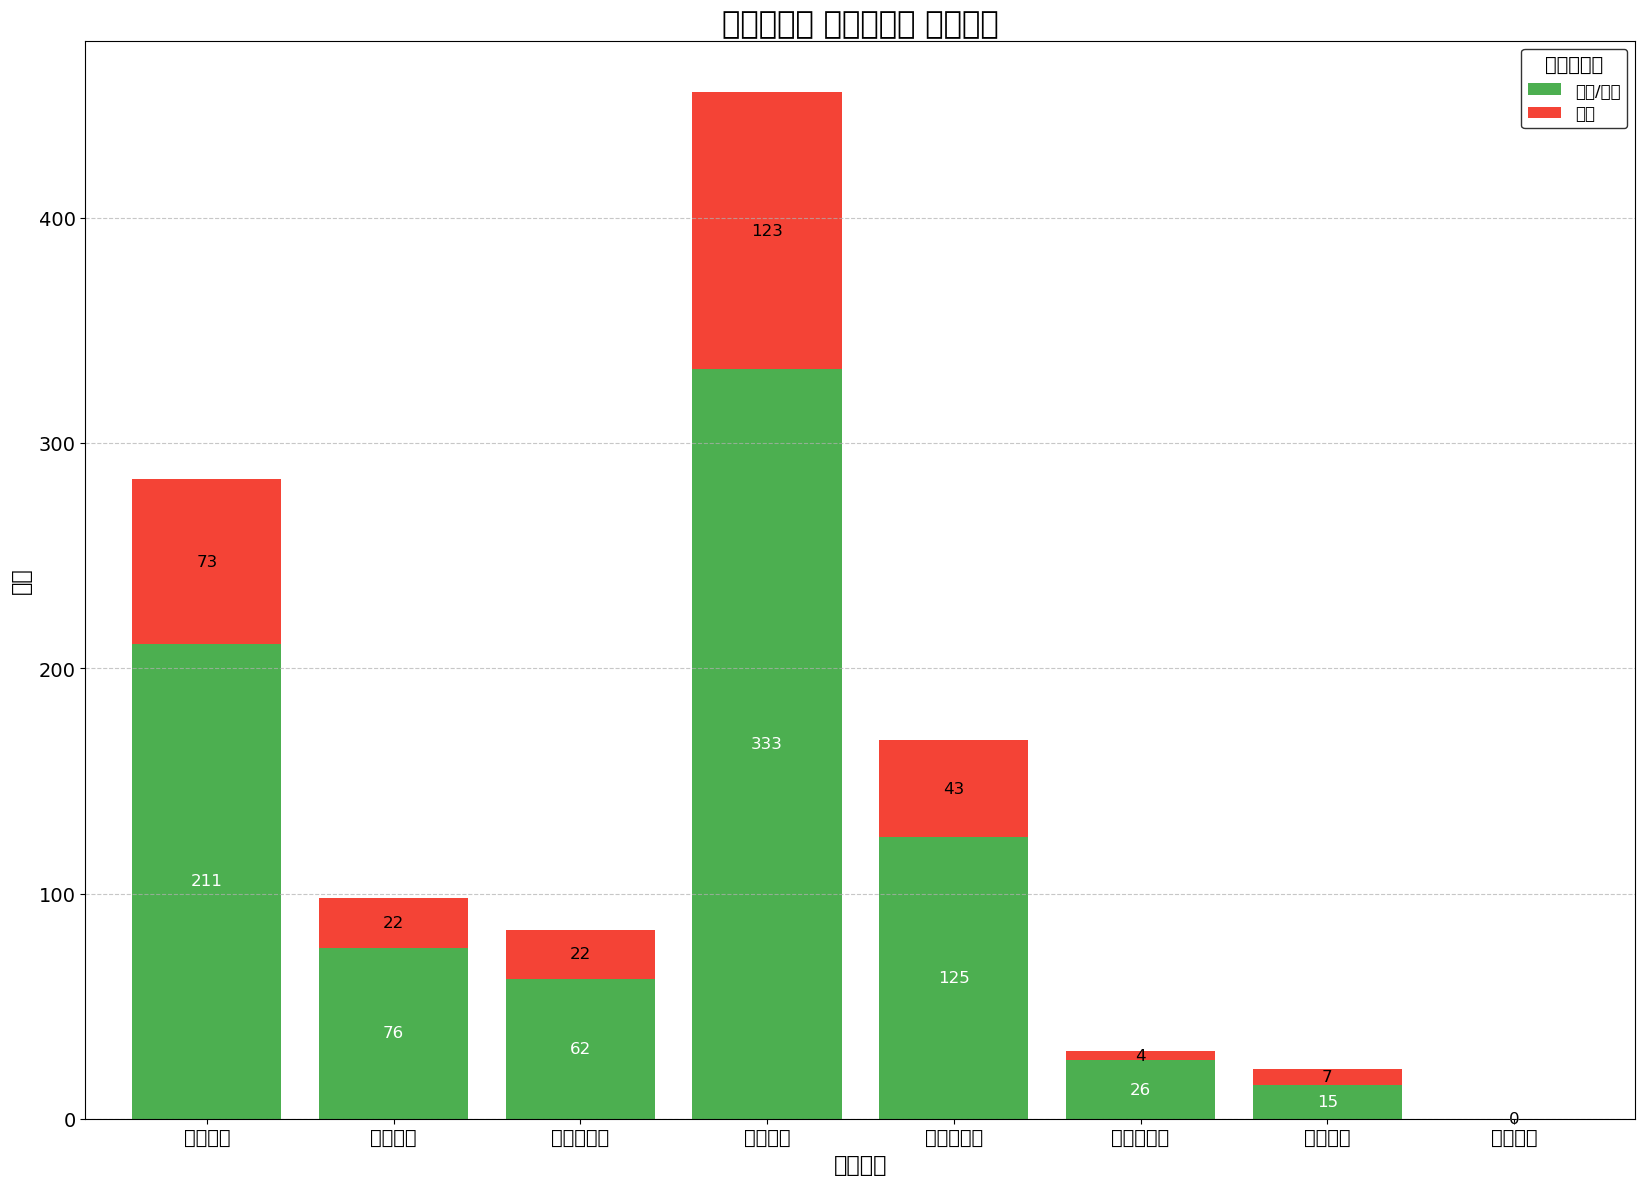

관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/관리지사별_영업상태명_집계현황_정렬.png
PDF 파일로 저장되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/관리지사별_영업상태명_집계현황_정렬.pdf
HTML 파일로 저장되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/관리지사별_영업상태명_집계현황_정렬.html


In [25]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import mpld3
import os

# 한글 폰트 설정 (맑은 고딕)
plt.rcParams['font.family'] = 'Malgun Gothic'
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 정확한 파일 경로 입력
file_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/0827일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# 'Unknown' 관리지사 및 SP담당 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당'])

# 관리지사별로 집계
grouped_df = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)

# 원하는 순서로 관리지사 정렬
desired_order = ['중앙지사', '강북지사', '서대문지사', '고양지사', '의정부지사', '남양주지사', '원주지사', '강릉지사']
grouped_df = grouped_df.reindex(desired_order)

# 관리지사별 현황표 생성
print("관리지사별 영업상태 현황표:")
print(grouped_df)

# 시각화 (막대 그래프)
fig, ax = plt.subplots(figsize=(20, 14))  # 그래프 크기를 크게 조정
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = grouped_df.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('관리지사별 영업상태명 집계현황', fontsize=22)
ax.set_xlabel('관리지사', fontsize=16)
ax.set_ylabel('건수', fontsize=16)
plt.xticks(fontsize=14, rotation=0, ha='center')  # 텍스트 수평 정렬
plt.yticks(fontsize=14)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=12, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', loc='upper right', frameon=True)

# 범례 배경과 테두리 설정
legend.get_frame().set_facecolor('white')  # 배경색
legend.get_frame().set_edgecolor('black')  # 테두리색

# 그래프에 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
fig_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 PDF로 저장
pdf_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.pdf')
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

# 그래프를 HTML로 저장
html_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.html')
mpld3.save_html(fig, html_path)

# 그래프를 출력
plt.show()

print(f"관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: {fig_path}")
print(f"PDF 파일로 저장되었습니다: {pdf_path}")
print(f"HTML 파일로 저장되었습니다: {html_path}")


Fontconfig warning: ignoring UTF-8: not a valid region tag
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/717596082.py:84: UserWarning: Glyph 44148 (\N{HANGUL SYLLABLE GEON}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/717596082.py:84: UserWarning: Glyph 49688 (\N{HANGUL SYLLABLE SU}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26

관리지사별 영업상태 현황표:
영업상태명  영업/정상     폐업
관리지사               
중앙지사   211.0   73.0
강북지사    76.0   22.0
서대문지사   62.0   22.0
고양지사   333.0  123.0
의정부지사  125.0   43.0
남양주지사   26.0    4.0
원주지사    15.0    7.0
강릉지사     NaN    NaN


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

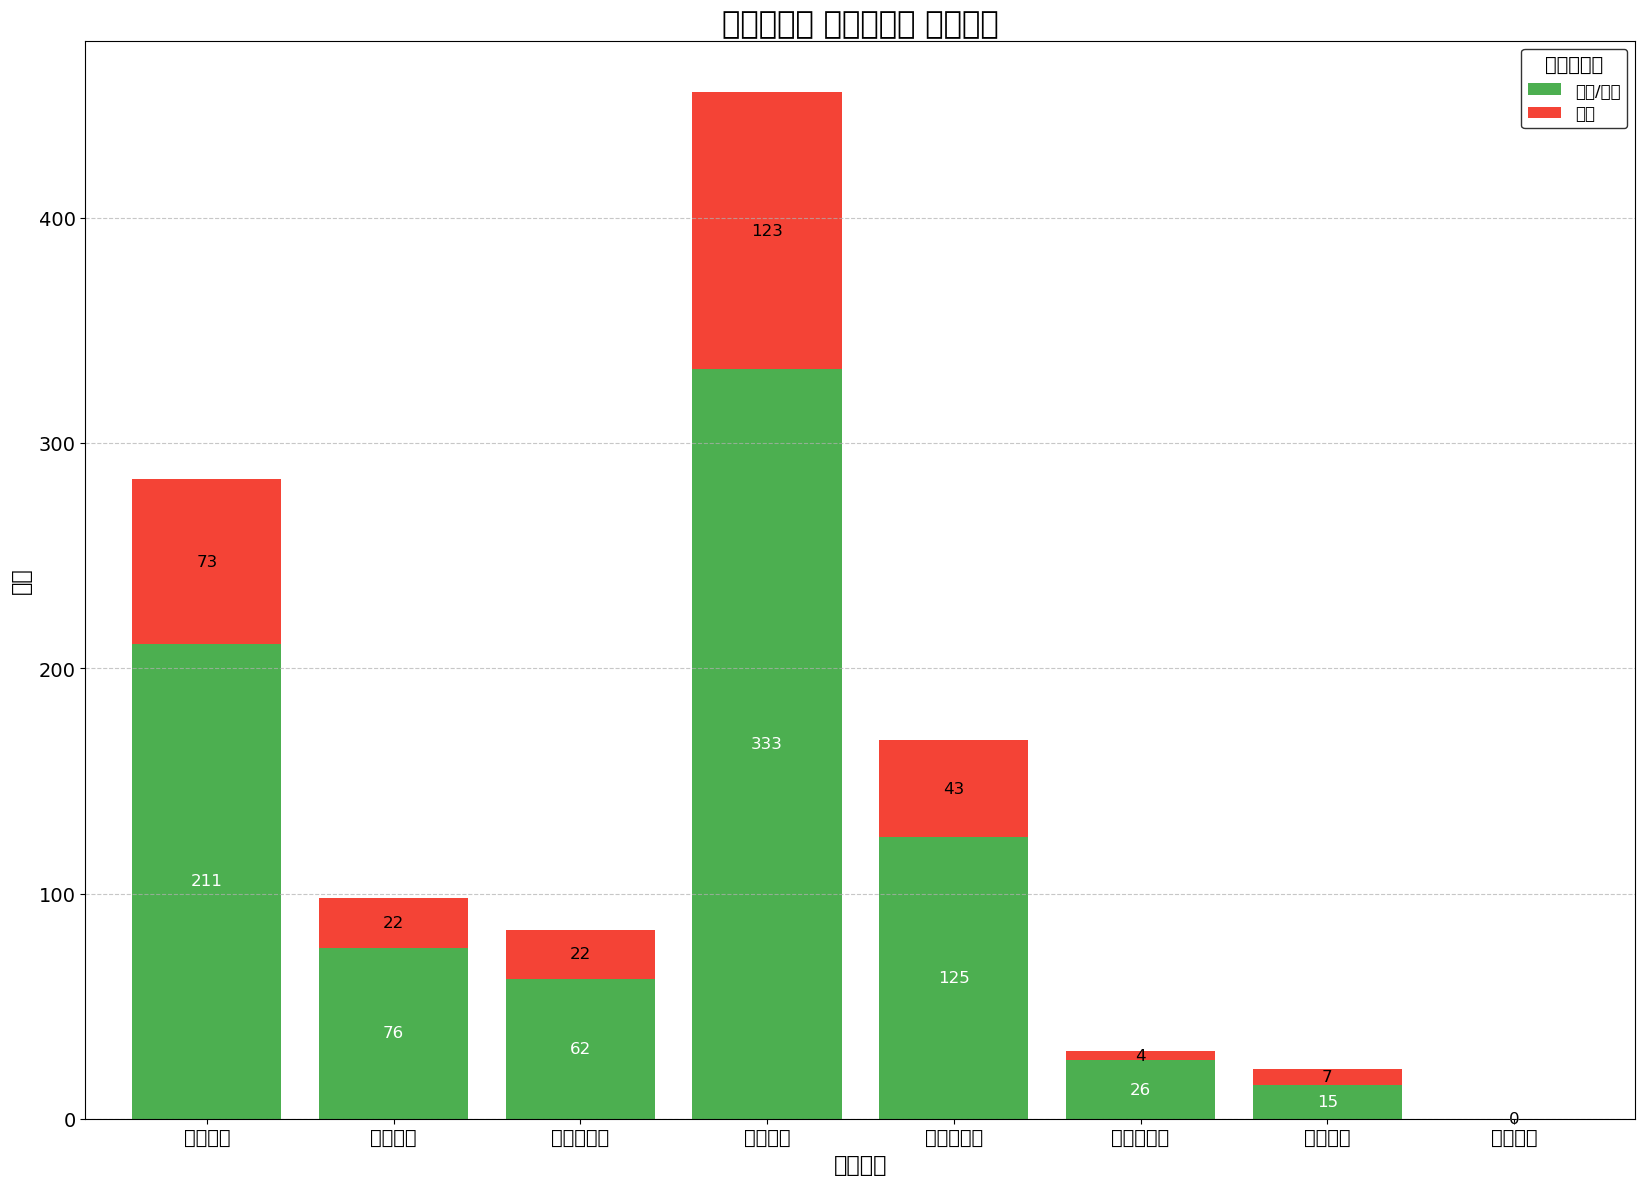

관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/관리지사별_영업상태명_집계현황_정렬.png
PDF 파일로 저장되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/관리지사별_영업상태명_집계현황_정렬.pdf
HTML 파일로 저장되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/관리지사별_영업상태명_집계현황_정렬.html


In [27]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import mpld3
import os

# Jupyter Notebook에서 사용할 수 있는 한글 폰트 설정
# MacOS의 경우, 'AppleGothic'을 사용할 수 있음
# Windows의 경우, 'Malgun Gothic' 또는 'NanumGothic'을 사용할 수 있음

if os.name == 'posix':  # MacOS, Linux
    if 'AppleGothic' in fm.findSystemFonts():
        plt.rcParams['font.family'] = 'AppleGothic'
    else:
        plt.rcParams['font.family'] = 'NanumGothic'
elif os.name == 'nt':  # Windows
    plt.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 정확한 파일 경로 입력
file_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/0827일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# 'Unknown' 관리지사 및 SP담당 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당'])

# 관리지사별로 집계
grouped_df = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)

# 원하는 순서로 관리지사 정렬
desired_order = ['중앙지사', '강북지사', '서대문지사', '고양지사', '의정부지사', '남양주지사', '원주지사', '강릉지사']
grouped_df = grouped_df.reindex(desired_order)

# 관리지사별 현황표 생성
print("관리지사별 영업상태 현황표:")
print(grouped_df)

# 시각화 (막대 그래프)
fig, ax = plt.subplots(figsize=(20, 14))  # 그래프 크기를 크게 조정
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = grouped_df.plot(kind='bar', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('관리지사별 영업상태명 집계현황', fontsize=22)
ax.set_xlabel('관리지사', fontsize=16)
ax.set_ylabel('건수', fontsize=16)
plt.xticks(fontsize=14, rotation=0, ha='center')  # 텍스트 수평 정렬
plt.yticks(fontsize=14)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=12, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', loc='upper right', frameon=True)

# 범례 배경과 테두리 설정
legend.get_frame().set_facecolor('white')  # 배경색
legend.get_frame().set_edgecolor('black')  # 테두리색

# 그래프에 그리드 추가
ax.grid(True, axis='y', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
fig_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 PDF로 저장
pdf_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.pdf')
with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

# 그래프를 HTML로 저장
html_path = os.path.join(output_dir, '관리지사별_영업상태명_집계현황_정렬.html')
mpld3.save_html(fig, html_path)

# 그래프를 출력
plt.show()

print(f"관리지사별 영업상태명 집계현황 그래프가 생성되었습니다: {fig_path}")
print(f"PDF 파일로 저장되었습니다: {pdf_path}")
print(f"HTML 파일로 저장되었습니다: {html_path}")


In [42]:
import pandas as pd
import os
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from difflib import SequenceMatcher

# 한글 폰트 설정
def set_font():
    plt.rcParams['font.family'] = 'NanumGothic'
    print(f"Font set to NanumGothic")

set_font()

# 경로 설정
csv_folder_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV'
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
file1_path = os.path.join('/Users/heebonpark/Desktop/업무/영업기회', '1.영업구역별_주소현행화0725.xlsx')
file2_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')
unknown_folder_path = '/Users/heebonpark/Desktop/업무/영업기회/Unknown'  # Unknown 데이터가 저장된 폴더 경로

# 경로 검증 함수
def validate_paths(*paths):
    for path in paths:
        if not os.path.exists(path):
            print(f"Error: The specified path '{path}' does not exist.")
        else:
            if os.path.isfile(path):
                print(f"File found: {path}")
            elif os.path.isdir(path):
                print(f"Directory found: {path}")
            else:
                print(f"Unknown type for path: {path}")

validate_paths(csv_folder_path, output_dir, file1_path, file2_path, unknown_folder_path)

# CSV 파일 읽기 및 필터링
all_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))
print(f"Found {len(all_files)} CSV files.")

if len(all_files) == 0:
    print("Warning: No CSV files found in the specified directory. Proceeding with an empty DataFrame.")
    dfs = []
else:
    dfs = []
    for file in all_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            address_columns = [col for col in df.columns if '주소' in col]
            if not address_columns:
                print(f"No address column found in file: {file}")
                continue
            df_filtered = df[df[address_columns[0]].str.contains('서울|경기|강원', na=False)]
            dfs.append(df_filtered)
            print(f"Successfully read and filtered file: {file}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

if len(dfs) == 0:
    concatenated_df = pd.DataFrame()
else:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'], inplace=True)

    if '인허가일자' in concatenated_df.columns:
        concatenated_df['인허가일자'] = pd.to_datetime(concatenated_df['인허가일자'], format='%Y%m%d', errors='coerce')
        concatenated_df.sort_values(by='인허가일자', ascending=False, inplace=True)

selected_columns = ['소재지전체주소', '도로명전체주소', '도로명우편번호', '사업장명', '개방서비스명', '인허가일자', '인허가취소', '영업상태명', '폐업일자',
                    '휴업시작일', '휴업종료일', '재개업일자', '소재지전화', '최종수정시점', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '총면적', '소재지면적']

existing_columns = [col for col in selected_columns if col in concatenated_df.columns]
filtered_df = concatenated_df[existing_columns]

os.makedirs(output_dir, exist_ok=True)
output_csv_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')
filtered_df.to_csv(output_csv_path, index=False, encoding='cp949')

df1 = pd.read_excel(file1_path)
df2 = pd.read_csv(output_csv_path, encoding='cp949')

# 주소 정규화 함수
def normalize_address(address):
    if pd.isna(address):
        return None
    address = address.strip()
    address = address.replace('강원특별자치도', '강원도')
    address = address.replace('서울특별시', '서울시')
    address = address.replace(' ', '')
    address = address.replace('-', '')
    if '*' in address or len(address) < 10:
        return None
    return address

# 유사도 계산 및 매칭 함수
def get_best_match(address, df_choices, threshold=0.7):
    if pd.isna(address):
        return None

    best_score = 0
    best_match = None

    for choice in df_choices:
        tfidf_vec = vectorizer.transform([choice])
        cosine_sim = cosine_similarity(vectorizer.transform([address]), tfidf_vec).flatten()[0]

        seq_match = SequenceMatcher(None, address, choice)
        seq_similarity = seq_match.ratio()

        score = max(cosine_sim, seq_similarity)
        if score > best_score:
            best_score = score
            best_match = choice

    if best_score >= threshold:
        return best_match
    return None

df1['full_address'] = df1[['주소시', '주소군구', '주소동']].astype(str).agg(' '.join, axis=1).apply(normalize_address)
df1 = df1.dropna(subset=['full_address'])

df2['소재지전체주소'] = df2['소재지전체주소'].astype(str).apply(normalize_address)
df2['도로명전체주소'] = df2['도로명전체주소'].astype(str).apply(normalize_address)
df2 = df2.dropna(subset=['소재지전체주소', '도로명전체주소'])

vectorizer = TfidfVectorizer().fit(df1['full_address'])
tfidf_matrix = vectorizer.transform(df1['full_address'])

choices = df1['full_address'].tolist()
df2['matched_address_소재지'] = df2['소재지전체주소'].apply(lambda x: get_best_match(x, choices))
df2['matched_address_도로명'] = df2['도로명전체주소'].apply(lambda x: get_best_match(x, choices))

df2['matched_address'] = df2.apply(lambda x: x['matched_address_소재지'] if pd.notna(x['matched_address_소재지']) else x['matched_address_도로명'], axis=1)

unmatched = df2[df2['matched_address'].isna()]
print("매핑되지 않은 항목 수:", len(unmatched))

# Unknown 데이터에서 추가 매핑 시도
unknown_files = glob.glob(os.path.join(unknown_folder_path, "*.csv"))
if unknown_files:
    print("Unknown 데이터에서 매핑 시도 중...")
    unknown_dfs = []
    for file in unknown_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            df['소재지전체주소'] = df['소재지전체주소'].apply(normalize_address)
            df['도로명전체주소'] = df['도로명전체주소'].apply(normalize_address)
            unknown_dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    
    unknown_df = pd.concat(unknown_dfs, ignore_index=True)
    unknown_df = unknown_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'])

    for index, row in unmatched.iterrows():
        match = get_best_match(row['소재지전체주소'], unknown_df['소재지전체주소'].tolist())
        if match:
            df2.at[index, 'matched_address'] = match

# 병합 및 업데이트
merge_columns = ['full_address', '관리지사', 'SP담당']
if '총면적' in df1.columns:
    merge_columns.append('총면적')
if '소재지면적' in df1.columns:
    merge_columns.append('소재지면적')

df_merged = df2.merge(df1[merge_columns], left_on='matched_address', right_on='full_address', how='left', suffixes=('', '_df1'))

# 매핑 결과 확인
print("매핑 후 관리지사 및 SP담당이 비어있는 행 수:", df_merged[['관리지사', 'SP담당']].isna().sum())

# SP담당자 누락 확인 및 처리
missing_sp = df_merged[df_merged['SP담당'].isna()]
if not missing_sp.empty:
    print(f"Warning: SP담당자가 누락된 데이터가 {len(missing_sp)}건 있습니다. 'Unknown'으로 설정합니다.")
    df_merged['SP담당'].fillna('Unknown', inplace=True)

def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]

        # 필터링된 데이터 개수 확인
        print(f"전체 시트에서 영업/정상 데이터 수: {len(df_active)}")

        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0827일.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '0827일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=False).index]

# 시각화 및 PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    status_counts.plot(kind='bar', stacked=True, ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=16)
    ax1.set_xlabel('관리지사', fontsize=12)
    ax1.set_ylabel('건수', fontsize=12)
    ax1.legend(title='영업상태명', fontsize=10, title_fontsize='13')
    plt.xticks(rotation=90)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']
    status_counts_sp = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
    status_counts_sp = status_counts_sp.loc[status_counts_sp.sum(axis=1).sort_values(ascending=True).index]

    fig2, ax2 = plt.subplots(figsize=(16, 12))
    status_counts_sp.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'])
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
    ax2.set_xlabel('건수', fontsize=14)
    ax2.set_ylabel('SP담당자', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"전체 영업상태명 집계현황 PDF가 생성되었습니다: {pdf_path}")


Font set to NanumGothic
Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV
Directory found: /Users/heebonpark/Desktop/업무/영업기회/0829
File found: /Users/heebonpark/Desktop/업무/영업기회/1.영업구역별_주소현행화0725.xlsx
File found: /Users/heebonpark/Desktop/업무/영업기회/0829/1.27일_병합(서울,경기,강원).csv
Error: The specified path '/Users/heebonpark/Desktop/업무/영업기회/Unknown' does not exist.
Found 195 CSV files.
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_09_30_12_P_수질오염원설치시설기타.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_03_05_01_P_게임물배급업.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_11_46_01_P_민방위급수시설.csv
Successfully read and filtered file: /Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV/(20240801~20240827)_10_41_01_P_체육도장업.csv
Successfully read and filtered f

/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:181: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_merged['SP담당'].fillna('Unknown', inplace=True)
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:198: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.drop_duplicates(inplace=T

전체 시트에서 영업/정상 데이터 수: 21006
전체 시트에서 영업/정상 데이터 수: 100
전체 시트에서 영업/정상 데이터 수: 63
전체 시트에서 영업/정상 데이터 수: 54
전체 시트에서 영업/정상 데이터 수: 83
전체 시트에서 영업/정상 데이터 수: 33
전체 시트에서 영업/정상 데이터 수: 40
전체 시트에서 영업/정상 데이터 수: 28
전체 시트에서 영업/정상 데이터 수: 50
전체 시트에서 영업/정상 데이터 수: 14
전체 시트에서 영업/정상 데이터 수: 75
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 27
전체 시트에서 영업/정상 데이터 수: 46
전체 시트에서 영업/정상 데이터 수: 3
전체 시트에서 영업/정상 데이터 수: 109
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 25
전체 시트에서 영업/정상 데이터 수: 1
전체 시트에서 영업/정상 데이터 수: 16
전체 시트에서 영업/정상 데이터 수: 20
전체 시트에서 영업/정상 데이터 수: 26
전체 시트에서 영업/정상 데이터 수: 4
전체 시트에서 영업/정상 데이터 수: 11
전체 시트에서 영업/정상 데이터 수: 21854


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:313: UserWarning: Glyph 44256 (\N{HANGUL SYLLABLE GO}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:313: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:313: UserWarning: Glyph 51648 (\N{HANGUL SYLLABLE JI}) missing from current font.
  plt.tight_layout()
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:313: UserWarning: Glyph 49324 (\N{HANGUL SYLLABLE SA}) missing from current font.
  plt.tight_layout()
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/370941281.py:313: Use

전체 영업상태명 집계현황 PDF가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황.pdf


In [ ]:
import pandas as pd
import os
import glob
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from openpyxl import Workbook
from openpyxl.utils.dataframe import dataframe_to_rows
from openpyxl.styles import Border, Side, Alignment, PatternFill, Font
import matplotlib.pyplot as plt
from matplotlib.backends.backend_pdf import PdfPages
from difflib import SequenceMatcher

# 한글 폰트 설정
def set_font():
    plt.rcParams['font.family'] = 'NanumGothic'
    print(f"Font set to NanumGothic")

set_font()

# 경로 설정
csv_folder_path = '/Users/heebonpark/Desktop/업무/영업기회/0829/LOCALDATA_NOWMON_CSV'
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
file1_path = os.path.join('/Users/heebonpark/Desktop/업무/영업기회', '1.영업구역별_주소현행화0725.xlsx')
file2_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')
unknown_folder_path = '/Users/heebonpark/Desktop/업무/영업기회/Unknown'

# 경로 검증 함수
def validate_paths(*paths):
    for path in paths:
        if not os.path.exists(path):
            print(f"Error: The specified path '{path}' does not exist.")
        else:
            if os.path.isfile(path):
                print(f"File found: {path}")
            elif os.path.isdir(path):
                print(f"Directory found: {path}")
            else:
                print(f"Unknown type for path: {path}")

validate_paths(csv_folder_path, output_dir, file1_path, file2_path, unknown_folder_path)

# CSV 파일 읽기 및 필터링
all_files = glob.glob(os.path.join(csv_folder_path, "*.csv"))
print(f"Found {len(all_files)} CSV files.")

if len(all_files) == 0:
    print("Warning: No CSV files found in the specified directory. Proceeding with an empty DataFrame.")
    dfs = []
else:
    dfs = []
    for file in all_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            address_columns = [col for col in df.columns if '주소' in col]
            if not address_columns:
                print(f"No address column found in file: {file}")
                continue
            df_filtered = df[df[address_columns[0]].str.contains('서울|경기|강원', na=False)]
            dfs.append(df_filtered)
            print(f"Successfully read and filtered file: {file}")
        except Exception as e:
            print(f"Error reading file {file}: {e}")

if len(dfs) == 0:
    concatenated_df = pd.DataFrame()
else:
    concatenated_df = pd.concat(dfs, ignore_index=True)
    concatenated_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'], inplace=True)

    if '인허가일자' in concatenated_df.columns:
        concatenated_df['인허가일자'] = pd.to_datetime(concatenated_df['인허가일자'], format='%Y%m%d', errors='coerce')
        concatenated_df.sort_values(by='인허가일자', ascending=False, inplace=True)

selected_columns = ['소재지전체주소', '도로명전체주소', '도로명우편번호', '사업장명', '개방서비스명', '인허가일자', '인허가취소', '영업상태명', '폐업일자',
                    '휴업시작일', '휴업종료일', '재개업일자', '소재지전화', '최종수정시점', '업태구분명', '좌표정보(X)', '좌표정보(Y)', '총면적', '소재지면적']

existing_columns = [col for col in selected_columns if col in concatenated_df.columns]
filtered_df = concatenated_df[existing_columns]

os.makedirs(output_dir, exist_ok=True)
output_csv_path = os.path.join(output_dir, '1.27일_병합(서울,경기,강원).csv')
filtered_df.to_csv(output_csv_path, index=False, encoding='cp949')

df1 = pd.read_excel(file1_path)
df2 = pd.read_csv(output_csv_path, encoding='cp949')

# 주소 정규화 함수
def normalize_address(address):
    if pd.isna(address):
        return None
    address = address.strip()
    address = address.replace('강원특별자치도', '강원도')
    address = address.replace('서울특별시', '서울시')
    address = address.replace(' ', '')
    address = address.replace('-', '')
    if '*' in address or len(address) < 10:
        return None
    return address

df1['full_address'] = df1[['주소시', '주소군구', '주소동']].astype(str).agg(' '.join, axis=1).apply(normalize_address)
df1 = df1.dropna(subset=['full_address'])

df2['소재지전체주소'] = df2['소재지전체주소'].astype(str).apply(normalize_address)
df2['도로명전체주소'] = df2['도로명전체주소'].astype(str).apply(normalize_address)
df2 = df2.dropna(subset=['소재지전체주소', '도로명전체주소'])

# 유사도 계산 함수: 시, 구, 군, 동, 면 등의 단위별로 비교
def calculate_similarity(address1, address2):
    if not address1 or not address2:
        return 0
    parts1 = address1.split()
    parts2 = address2.split()
    
    # 기본 TF-IDF 및 레벤슈타인 유사도 계산
    tfidf_vec1 = vectorizer.transform([address1])
    tfidf_vec2 = vectorizer.transform([address2])
    cosine_sim = cosine_similarity(tfidf_vec1, tfidf_vec2).flatten()[0]

    seq_match = SequenceMatcher(None, address1, address2)
    seq_similarity = seq_match.ratio()

    # 행정 구역 단위별 일치율 계산
    match_score = sum(1 for p1, p2 in zip(parts1, parts2) if p1 == p2) / max(len(parts1), len(parts2))

    # 평균 유사도 반환
    return (cosine_sim + seq_similarity + match_score) / 3

# 유사한 주소 매핑 함수
def get_best_match(address, df_choices, threshold=0.75):
    best_score = 0
    best_match = None

    for choice in df_choices:
        score = calculate_similarity(address, choice)
        if score > best_score:
            best_score = score
            best_match = choice

    if best_score >= threshold:
        return best_match
    return None

vectorizer = TfidfVectorizer().fit(df1['full_address'])
choices = df1['full_address'].tolist()
df2['matched_address_소재지'] = df2['소재지전체주소'].apply(lambda x: get_best_match(x, choices))
df2['matched_address_도로명'] = df2['도로명전체주소'].apply(lambda x: get_best_match(x, choices))

df2['matched_address'] = df2.apply(lambda x: x['matched_address_소재지'] if pd.notna(x['matched_address_소재지']) else x['matched_address_도로명'], axis=1)

unmatched = df2[df2['matched_address'].isna()]
print("매핑되지 않은 항목 수:", len(unmatched))

# Unknown 데이터에서 추가 매핑 시도
unknown_files = glob.glob(os.path.join(unknown_folder_path, "*.csv"))
if unknown_files:
    print("Unknown 데이터에서 매핑 시도 중...")
    unknown_dfs = []
    for file in unknown_files:
        try:
            df = pd.read_csv(file, encoding='cp949', on_bad_lines='skip', dtype=str, low_memory=False)
            df['소재지전체주소'] = df['소재지전체주소'].apply(normalize_address)
            df['도로명전체주소'] = df['도로명전체주소'].apply(normalize_address)
            unknown_dfs.append(df)
                except Exception as e:
            print(f"Error reading file {file}: {e}")
    
    unknown_df = pd.concat(unknown_dfs, ignore_index=True)
    unknown_df = unknown_df.drop_duplicates(subset=['사업장명', '소재지전체주소', '영업상태명'])

    for index, row in unmatched.iterrows():
        match = get_best_match(row['소재지전체주소'], unknown_df['소재지전체주소'].tolist())
        if match:
            df2.at[index, 'matched_address'] = match

# 병합 및 업데이트
merge_columns = ['full_address', '관리지사', 'SP담당']
if '총면적' in df1.columns:
    merge_columns.append('총면적')
if '소재지면적' in df1.columns:
    merge_columns.append('소재지면적')

df_merged = df2.merge(df1[merge_columns], left_on='matched_address', right_on='full_address', how='left', suffixes=('', '_df1'))

# 매핑 결과 확인
print("매핑 후 관리지사 및 SP담당이 비어있는 행 수:", df_merged[['관리지사', 'SP담당']].isna().sum())

# SP담당자 누락 확인 및 처리
missing_sp = df_merged[df_merged['SP담당'].isna()]
if not missing_sp.empty:
    print(f"Warning: SP담당자가 누락된 데이터가 {len(missing_sp)}건 있습니다. 'Unknown'으로 설정합니다.")
    df_merged['SP담당'].fillna('Unknown', inplace=True)

def calculate_area(row):
    if '소재지면적' in row and pd.notna(row['소재지면적']):
        return round(row['소재지면적'] / 3.305785, 2)
    elif '총면적' in row and pd.notna(row['총면적']):
        return round(row['총면적'] / 3.305785, 2)
    else:
        return None

df_merged['평수'] = df_merged.apply(calculate_area, axis=1)

# 불필요한 열 제외하고 필요한 열만 선택
columns_to_keep = ['관리지사', 'SP담당', '사업장명', '개방서비스명', '업태구분명', '평수', '소재지전체주소', '도로명전체주소', '소재지전화', '폐업일자', '재개업일자', '영업상태명']
df_filtered = df_merged[columns_to_keep]

# 중복된 항목 제거
df_filtered.drop_duplicates(inplace=True)

# 평수 내림차순 정렬
df_filtered_sorted = df_filtered.sort_values(by='평수', ascending=False)

# NaN 값 처리
df_filtered_sorted['관리지사'] = df_filtered_sorted['관리지사'].fillna('Unknown')
df_filtered_sorted['SP담당'] = df_filtered_sorted['SP담당'].fillna('Unknown')

# 네이버 지도 하이퍼링크 생성 함수
def create_naver_map_link(address):
    return f"https://map.naver.com/v5/search/{address}"

# 엑셀 파일에 네이버 지도 링크 추가하는 함수
def add_naver_map_links(ws, address_col_idx):
    ws.insert_cols(1)  # 첫 번째 열에 열 추가
    ws.cell(row=1, column=1, value="네이버 지도 링크")  # 새 열에 헤더 추가

    for row in range(2, ws.max_row + 1):
        address = ws.cell(row=row, column=address_col_idx + 1).value
        if address:
            link = create_naver_map_link(address)
            ws.cell(row=row, column=1).hyperlink = link
            ws.cell(row=row, column=1).value = "네이버 지도 보기"
            ws.cell(row=row, column=1).style = "Hyperlink"

# 엑셀 파일에 데이터를 저장하고 스타일을 설정하는 함수
def save_to_excel(df, file_path):
    with pd.ExcelWriter(file_path, engine='openpyxl') as writer:
        # 전체 시트 저장
        df.to_excel(writer, index=False, sheet_name='전체')

        # 영업/정상 시트 저장
        df_active = df[df['영업상태명'].isin(['영업/정상'])]

        # 필터링된 데이터 개수 확인
        print(f"전체 시트에서 영업/정상 데이터 수: {len(df_active)}")

        df_active.to_excel(writer, index=False, sheet_name='영업_정상')

        # 폐업 시트 저장
        df_closed = df[df['영업상태명'] == '폐업']
        df_closed.to_excel(writer, index=False, sheet_name='폐업')

        workbook = writer.book
        thin_border = Border(left=Side(style='thin', color='D3D3D3'),
                             right=Side(style='thin', color='D3D3D3'),
                             top=Side(style='thin', color='D3D3D3'),
                             bottom=Side(style='thin', color='D3D3D3'))
        header_fill = PatternFill(start_color="000080", end_color="000080", fill_type="solid")
        header_font = Font(color="FFFFFF", bold=True)

        # 스타일 설정 함수
        def set_style(worksheet):
            for cell in worksheet[1]:
                cell.fill = header_fill
                cell.font = header_font
                cell.border = thin_border
                cell.alignment = Alignment(horizontal='center', vertical='center')
            for row in worksheet.iter_rows(min_row=2):
                for cell in row:
                    cell.border = thin_border
                    cell.alignment = Alignment(horizontal='center', vertical='center')
            for col in worksheet.columns:
                max_length = 0
                column = col[0].column_letter
                for cell in col:
                    try:
                        if len(str(cell.value)) > max_length:
                            max_length = len(cell.value)
                    except:
                        pass
                adjusted_width = (max_length + 2)
                worksheet.column_dimensions[column].width = adjusted_width

        set_style(writer.sheets['전체'])
        set_style(writer.sheets['영업_정상'])
        set_style(writer.sheets['폐업'])

        # 네이버 지도 링크 추가
        add_naver_map_links(writer.sheets['전체'], 7)
        add_naver_map_links(writer.sheets['영업_정상'], 7)
        add_naver_map_links(writer.sheets['폐업'], 7)

# 전체 데이터를 바탕으로 시각화 및 파일 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829'
for manager in df_filtered_sorted['관리지사'].unique():
    manager_dir = os.path.join(output_dir, manager)
    os.makedirs(manager_dir, exist_ok=True)
    df_manager = df_filtered_sorted[df_filtered_sorted['관리지사'] == manager]

    for sp in df_manager['SP담당'].unique():
        df_sp = df_manager[df_manager['SP담당'] == sp]
        sp_file_path = os.path.join(manager_dir, f'{manager}_{sp}_0827일.xlsx')
        save_to_excel(df_sp, sp_file_path)

# 전체 데이터를 저장
total_file_path = os.path.join(output_dir, '0827일_전체_최종결과물.xlsx')
save_to_excel(df_filtered_sorted, total_file_path)

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['관리지사', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=False).index]

# 시각화 및 PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황.pdf')
with PdfPages(pdf_path) as pdf:
    # 시각화 1: 관리지사별 영업상태명 집계현황
    fig1, ax1 = plt.subplots(figsize=(14, 10))
    status_counts.plot(kind='bar', stacked=True, ax=ax1, color=['skyblue', 'salmon'])
    ax1.set_title('관리지사별 영업상태명 집계현황', fontsize=16)
    ax1.set_xlabel('관리지사', fontsize=12)
    ax1.set_ylabel('건수', fontsize=12)
    ax1.legend(title='영업상태명', fontsize=10, title_fontsize='13')
    plt.xticks(rotation=90)
    plt.tight_layout()
    pdf.savefig(fig1)
    plt.close(fig1)

    # 시각화 2: SP담당자별 영업상태명 집계현황
    df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']
    status_counts_sp = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
        status_counts_sp = status_counts_sp.loc[status_counts_sp.sum(axis=1).sort_values(ascending=True).index]

    fig2, ax2 = plt.subplots(figsize=(16, 12))
    status_counts_sp.plot(kind='barh', stacked=True, ax=ax2, color=['#4caf50', '#f44336'])
    ax2.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
    ax2.set_xlabel('건수', fontsize=14)
    ax2.set_ylabel('SP담당자', fontsize=14)
    plt.tight_layout()
    pdf.savefig(fig2)
    plt.close(fig2)

print(f"전체 영업상태명 집계현황 PDF가 생성되었습니다: {pdf_path}")            

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:79: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:79: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:79: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:79: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  fig.savefig(fig_path, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:79: 

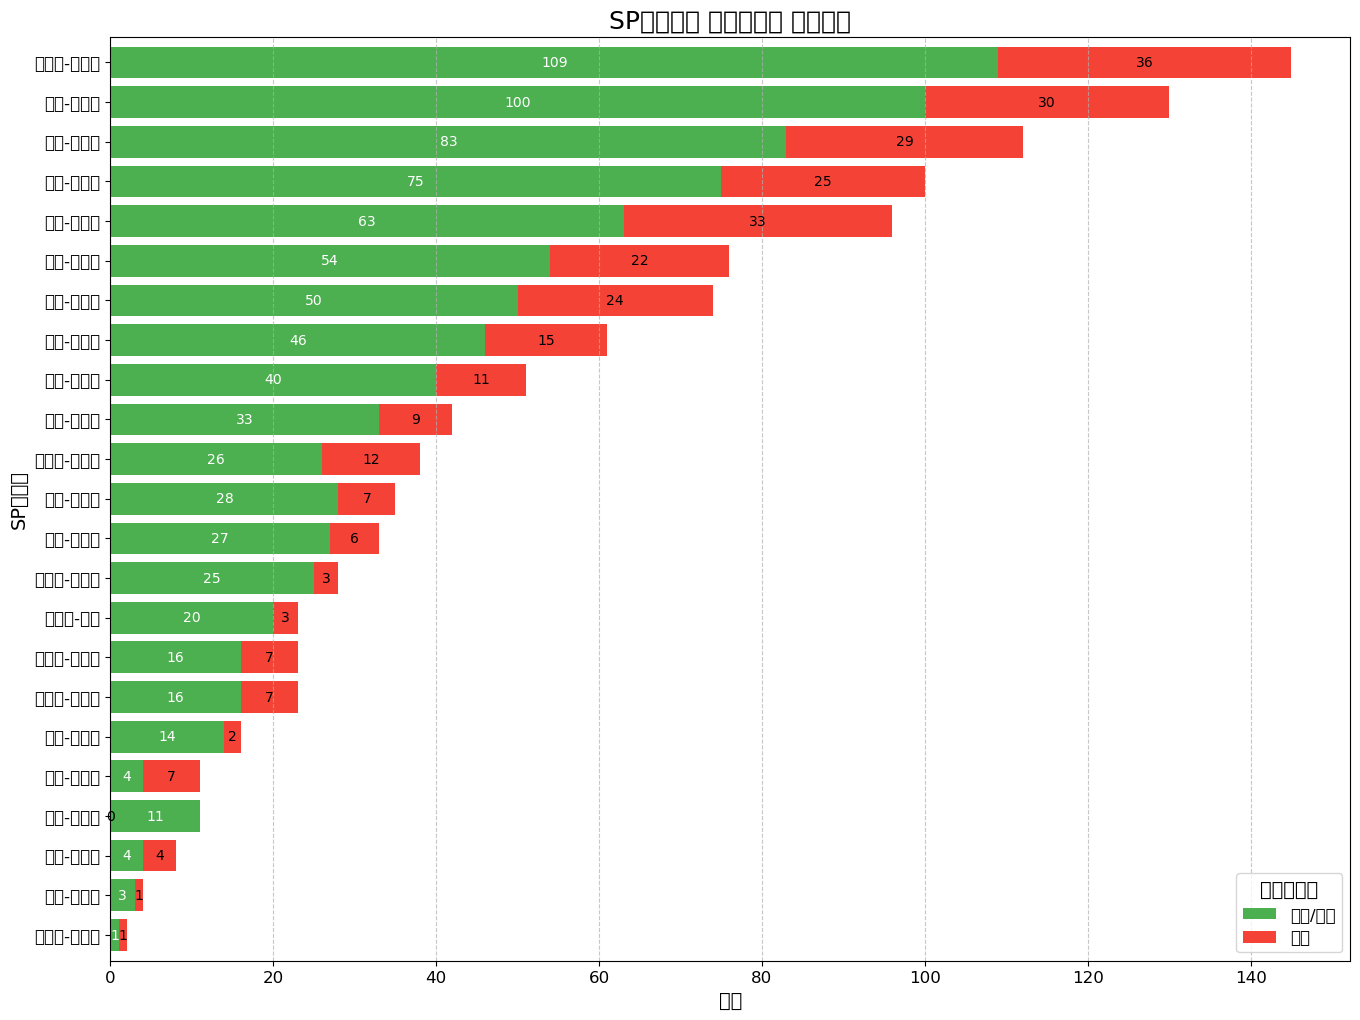

findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:94: UserWarning: Glyph 45224 (\N{HANGUL SYLLABLE NAM}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:94: UserWarning: Glyph 50577 (\N{HANGUL SYLLABLE YANG}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:94: UserWarning: Glyph 51452 (\N{HANGUL SYLLABLE JU}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:94: UserWarning: Glyph 51312 (\N{HANGUL SYLLABLE JO}) missing from current font.
  pdf.savefig(fig, bbox_inches='tight')
/var/folders/_f/8db5fbdx6_j62bmzy_26gf180000gn/T/ipykernel_26900/1339325943.py:94: UserWarning: Glyph 5

전체 영업상태명 집계현황 전문가 그래프가 생성되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황_전문가_0829.png


findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Font family 'NanumGothic' not found.
findfont: Fon

PDF 파일로 저장되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황0829.pdf
HTML 파일로 저장되었습니다: /Users/heebonpark/Desktop/업무/영업기회/0829/전체_영업상태명_집계현황_전문가_0829.html


In [47]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import pandas as pd
from matplotlib.backends.backend_pdf import PdfPages
import mpld3
import os

# Jupyter Notebook에서 사용할 수 있는 한글 폰트 설정
# MacOS의 경우, 'AppleGothic'을 사용할 수 있음
# Windows의 경우, 'Malgun Gothic' 또는 'NanumGothic'을 사용할 수 있음

if os.name == 'posix':  # MacOS, Linux
    if 'AppleGothic' in fm.findSystemFonts():
        font_name = 'AppleGothic'
    else:
        font_name = 'NanumGothic'
elif os.name == 'nt':  # Windows
    font_name = 'Malgun Gothic'

# 설정된 폰트를 matplotlib에 적용
plt.rcParams['font.family'] = font_name
plt.rcParams['axes.unicode_minus'] = False  # 마이너스 기호 깨짐 방지

# 정확한 파일 경로 입력
file_path = '/Users/heebonpark/Desktop/업무/영업기회/0829 복사본/0827일_전체_최종결과물.xlsx'

if not os.path.exists(file_path):
    raise FileNotFoundError(f"{file_path} 파일이 존재하지 않습니다. 경로를 확인하세요.")

# 데이터 프레임 읽기
df_filtered_sorted = pd.read_excel(file_path)

# '중앙' 지사 및 'Unknown' 제외
df_filtered_sorted = df_filtered_sorted[(df_filtered_sorted['관리지사'] != '중앙') &
                                        (df_filtered_sorted['관리지사'] != 'Unknown') &
                                        (df_filtered_sorted['SP담당'] != 'Unknown')]

# 담당자 앞에 관리지사 이름 추가 (지사 제외)
df_filtered_sorted['SP담당자'] = df_filtered_sorted['관리지사'].str.replace('지사', '') + '-' + df_filtered_sorted['SP담당']

# '영업/정상'과 '폐업' 상태만 필터링
df_filtered_sorted = df_filtered_sorted[df_filtered_sorted['영업상태명'].isin(['영업/정상', '폐업'])]

# 매핑된 데이터만 필터링
df_filtered_sorted = df_filtered_sorted.dropna(subset=['관리지사', 'SP담당'])

# 전체 데이터를 바탕으로 시각화
status_counts = df_filtered_sorted.groupby(['SP담당자', '영업상태명']).size().unstack(fill_value=0)
status_counts = status_counts.loc[status_counts.sum(axis=1).sort_values(ascending=True).index]

# 시각화 (가로 막대 그래프)
fig, ax = plt.subplots(figsize=(16, 12))
colors = ['#4caf50', '#f44336']  # 영업/정상 = 녹색, 폐업 = 빨간색

# 막대 그래프 생성
bars = status_counts.plot(kind='barh', stacked=True, ax=ax, color=colors, width=0.8)

# 그래프 제목 및 레이블 설정
ax.set_title('SP담당자별 영업상태명 집계현황', fontsize=18)
ax.set_xlabel('건수', fontsize=14)
ax.set_ylabel('SP담당자', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

# 막대에 숫자 표시
for container in bars.containers:
    bars.bar_label(container, label_type='center', fontsize=10, color='white' if container.get_label() == '영업/정상' else 'black')

# 범례 설정
handles, labels = ax.get_legend_handles_labels()
legend = ax.legend(handles, labels, title='영업상태명', fontsize=12, title_fontsize='14', loc='lower right')

# 그래프에 그리드 추가
ax.grid(True, axis='x', linestyle='--', alpha=0.7)

# 그래프를 이미지로 저장
output_dir = '/Users/heebonpark/Desktop/업무/영업기회/0829/'
fig_path = os.path.join(output_dir, '전체_영업상태명_집계현황_전문가_0829.png')
fig.savefig(fig_path, bbox_inches='tight')

# 그래프를 HTML로 저장
html_path = os.path.join(output_dir, '전체_영업상태명_집계현황_전문가_0829.html')
mpld3.save_html(fig, html_path)

# 그래프를 출력
plt.show()

print(f"전체 영업상태명 집계현황 전문가 그래프가 생성되었습니다: {fig_path}")

# 추가: PDF 저장
pdf_path = os.path.join(output_dir, '전체_영업상태명_집계현황0829.pdf')

with PdfPages(pdf_path) as pdf:
    pdf.savefig(fig, bbox_inches='tight')

print(f"PDF 파일로 저장되었습니다: {pdf_path}")
print(f"HTML 파일로 저장되었습니다: {html_path}")
